In [1]:
import numpy as np
import pandas as pd 

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

Corona=pd.read_csv('datasets/Corona_NLP_train.csv',encoding='latin1')

Corona.Sentiment.replace(to_replace='Extremely Positive', value='Positive',inplace=True)
Corona.Sentiment.replace(to_replace='Extremely Negative', value='Negative',inplace=True)
print(Corona.Sentiment.value_counts())
Corona = Corona[['OriginalTweet','Sentiment']]
Corona.head(10)

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive
7,Was at the supermarket today. Didn't buy toile...,Neutral
8,Due to COVID-19 our retail store and classroom...,Positive
9,"For corona prevention,we should stop to buy th...",Negative


In [3]:
import re
import string
from nltk.tokenize import word_tokenize
stop_words = stopwords.words("english")
def clean_text(text):
    text = text.lower()
    # remove mentions
    text = re.sub("@\S+", " ", text)
    # remove url
    text = re.sub("https*\S+", " ", text)
    # remove hashtags
    text = re.sub("#\S+", " ", text)
    # remove all numbers
    text = re.sub("\d", " ", text)
    # remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remove extra spaces
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    # stopwords     
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # remove non-Latin characters
    text = re.sub('[^a-zA-Z\s]', '', text)
    return text






Corona.OriginalTweet=Corona.OriginalTweet.apply(clean_text)

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def eval_model(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted) 
    cm_display=ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    print('accuracy score',accuracy_score(y_true, y_predicted))
    print(classification_report(y_true,y_predicted))

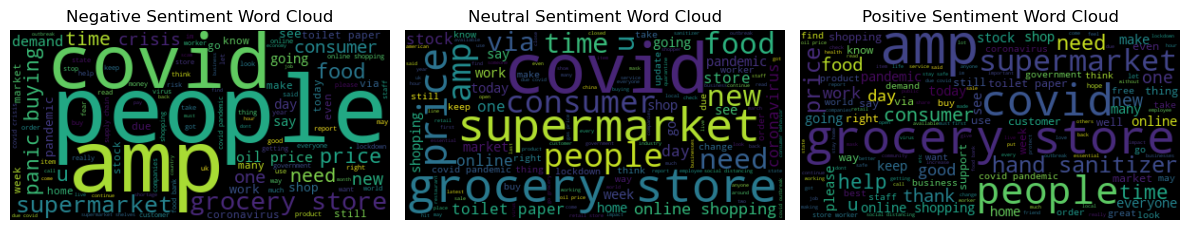

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_text = ' '.join(Corona[Corona.Sentiment == 'Negative'].OriginalTweet.tolist())
neutral_text = ' '.join(Corona[Corona.Sentiment == 'Neutral'].OriginalTweet.tolist())
positive_text = ' '.join(Corona[Corona.Sentiment == 'Positive'].OriginalTweet.tolist())

negative_wordcloud = WordCloud().generate(negative_text)
neutral_wordcloud = WordCloud().generate(neutral_text)
positive_wordcloud = WordCloud().generate(positive_text)

plt.figure(figsize=(12, 8))

plt.subplot(131)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.subplot(132)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')

plt.subplot(133)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

texts=Corona.OriginalTweet

Corona.OriginalTweet=Corona.OriginalTweet.apply(word_tokenize)
MAX_SEQUENCE_LENGTH = 40
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y=np.array(Corona.Sentiment)
print(data.shape)
print(Corona.Sentiment.shape)

Found 32832 unique tokens.
(41157, 40)
(41157,)


In [7]:
path='glove.6B.100d.txt'
embeddings_index = {}
with open(path, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [8]:
from keras.layers import Embedding
from keras.initializers import Constant

embedding_dim = 100
  
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector        

In [9]:
from sklearn.model_selection import train_test_split
labels_dict={'Positive': 2, 'Negative': 0, 'Neutral': 1}

y_final = []
for yi in y:
    y_final.append(labels_dict[yi])

data=np.array(data)   
y_final=np.array(y_final)  
    
X_train, X_test, y_train, y_test=train_test_split(data,y_final,test_size=.2)

In [10]:
X_test.shape

(8232, 40)

In [11]:
from keras.models import Sequential
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, Activation
import tensorflow as tf

model1 = Sequential()
model1.add(Embedding(len(word_index) + 1, embedding_dim, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(3, activation='softmax')) 

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

model1.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           3283300   
                                                                 
 lstm (LSTM)                 (None, 40, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 3444403 (13.14 MB)
Trainable params: 161103 (629.31 KB)
Non-trainable params: 3283300 (12.52 MB)
_________________________________________________________________
Epoch 1/20
412/412 [==============================] - 57s 116ms/step - loss: 0.8008 - accuracy: 0.6423 - val_loss: 0.7134 - val_accuracy: 0.692

258/258 [==============================] - 3s 11ms/step
accuracy score 0.8266520894071915
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      3076
           1       0.80      0.77      0.79      1610
           2       0.84      0.85      0.84      3546

    accuracy                           0.83      8232
   macro avg       0.82      0.82      0.82      8232
weighted avg       0.83      0.83      0.83      8232



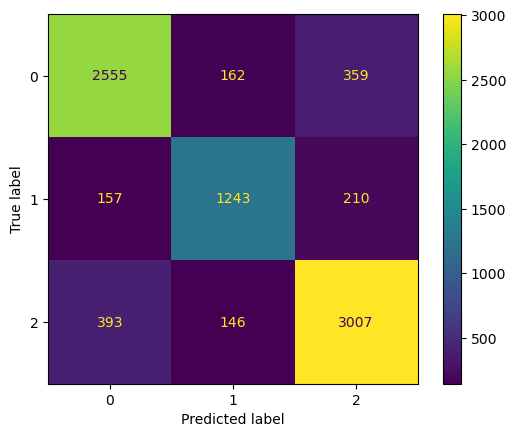

In [12]:
y_pred=np.argmax(model1.predict(X_test),axis=1)
eval_model(y_test,y_pred)

In [13]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, embedding_dim, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model2.add(GRU(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model2.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(3, activation='softmax')) 

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

model2.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           3283300   
                                                                 
 gru (GRU)                   (None, 40, 100)           60600     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 3404803 (12.99 MB)
Trainable params: 121503 (474.62 KB)
Non-trainable params: 3283300 (12.52 MB)
_________________________________________________________________
Epoch 1/20
412/412 [==============================] - 33s 72ms/step - loss: 0.7917 - accuracy: 0.6465 - val_loss: 0.6881 - val_accuracy: 0.70

258/258 [==============================] - 3s 9ms/step
accuracy score 0.8154761904761905
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3076
           1       0.80      0.72      0.76      1610
           2       0.81      0.87      0.84      3546

    accuracy                           0.82      8232
   macro avg       0.81      0.80      0.80      8232
weighted avg       0.82      0.82      0.81      8232



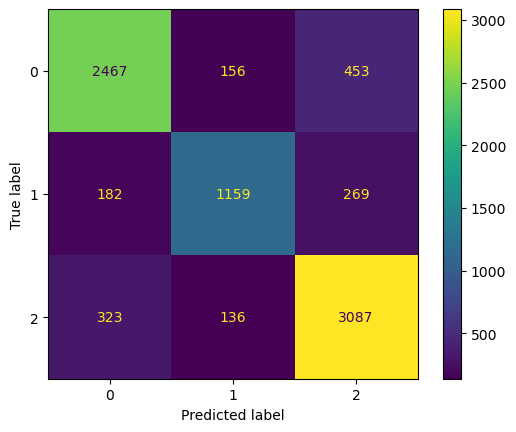

In [14]:
y_pred=np.argmax(model2.predict(X_test),axis=1)
eval_model(y_test,y_pred)